In [5]:
from IPython.core.display import HTML
table_css = 'table {align:left;display:block}'
HTML('<style>{}</style>'.format(table_css))

# Calculate Water Scarcity from ISIMIP2b

Main script to postprocess ISIMIP output and calculate water scarcity indices



**TO DO**
- check ptotww values calculation for MATSIRO and LPJmL

**Notes**
- industrial = elec+manu (some models have it seperately)
- Not all GHMs use DDM30: to check for each! (CLM not, JULES not)
- Implications with how actual water use is defined/modeled in H08 (no constraints?) see mail Naota
- How to represent local water availability? dis - dis_upstream grid cell => how much water is produced locally, but in the dis term the water use is already distracted. 
- qrunoff is result of only local processes and then goes through lateral flow (reservoirs and lakes) for some models like WaterGAP, use for local water availability discharge from the direct upstream gridcells, plus the local runoff (discharge of the cell itself is already subtracted with the water demand)
- H08 (and maybe others): actual water use == pot water use (no limitations in ISIMIP simulations): double check mail Naota

**Model availability** 


|                  | rcp26soc          | rcp26soc        | rcp60soc           | rcp60soc        |
|------------------|:--------         :|:------:         | :------:           |:------:         |
|                  |          dis/qtot |          use/ww |          dis/qtot  |          use/ww |
| **CWatM**        | x                 | x               |  x                 | x               |  
| **H08**          | x                 | x               |  x                 | x               |  
| **LPJmL**        | x                 | o               |  x                 | o               |  
| **MATSIRO**      | x                 | o               |  x                 | o               |  
| **WaterGAP2-2e** | o                 | o               |  o                 | o               | 


In [6]:
# import modules
import os
import xarray as xr
import matplotlib.pyplot as plt
# define isimip phase  - different initialisation needed

# define phase manually in init script
from init import *

from functions import *
#from calc_upstream import *
import pandas as pd

# to show plots in the notebook
%matplotlib inline 
set_plot_param()
    

# flags
testing = False
calc_wsindex = False
load_wsindex = False
calc_exposure = True
calc_duration = False
calc_falkenmark= False
save_intermediate = True
preprocess_pop = True
calc_waterdeficit = False
calc_waterdeficit_duration = False
calc_waterdeficit_intensity = False

calc_withdrawal_persector = True
calc_deficit_persector = True
aggregation_flag = 'sum' # sum:  number of exposerd months per year
                         # binary: calculate annual maximum (at least one month with water scarcity => water scarce year)
                        # integer: number of months per year that need to be water scarce in order to have a waterscarce year. 
save_annual = False
# water scarcity threshold
ws_threshold = 0.4
falkenmark_threshold = 1000 # m³/cap



In [2]:
# define ISIMIP models, forcings and variables
models    = ['H08', 'CWatM', 'LPJmL', 'MATSIRO']

forcings  = ['gfdl-esm2m', 'ipsl-cm5a-lr', 'hadgem2-es', 'miroc5']

# do initialisation of global variables
# define directory where to put processed netcdf files

if testing: 

    # for testing, only load one model and forcing
    models = [models[0]]
    forcings = [forcings[0]]
    scenarios = [scenarios[0]]
    
    model = models[0]
    scenario = scenarios[0]
    forcing = forcings[0]
                    

In [3]:
# Load routing data

#da_flowdir = xr.open_dataarray(routingdir +'ddm30_flowdir_cru_neva.nc')
da_basins  = xr.open_dataarray(routingdir +'ddm30_basins_cru_neva.nc')
#da_slopes  = xr.open_dataarray(routingdir +'ddm30_slopes_cru_neva.nc')

# load cell area
da_cellarea = xr.open_dataarray( scriptsdir+'/data/upstream_calc/cellarea.nc')

# load land mask
landmask = da_basins>0


FileNotFoundError: [Errno 2] No such file or directory: '/rhea/scratch/brussel/vo/000/bvo00012/vsc10055/waterscarcity/2025_Vanderkelen_etal/preprocessing_isimip/data/upstream_calc/cellarea.nc'

## Determine water availability
### Do preprocessing on summing runoff and discharge for all simulations
Done as batch jobs per model by seperate script [upstream_calc.py](calc_upstream.py). 

The output, summed discharge of all direct upstream grid cells (`dis_directupstream`) and summed runoff of all upstream grid cells (`qtot_allupstream`), is saved per model in [./data/intermediate/](data/intermediate)
                    



## Detemine potential water withdrawal 


Water withdrawals/use per model ( see excel table also)

|                  | domestic          | industrial/man  | irrigation         |
|------------------|:--------         :|:------:         | :------:           |
| **CWatM**        | adomuse           | ainduse         |  pirrww            | 
| **H08**          | adomww            | amanww          |  pirrww            | 
| **LPJmL**        | o                 | o               |  pirrww            |  
| **MATSIRO**      | o                | o               |  pirrww            | 


For MATSIRO and LPJmL, no domestic and industrial water withdrawals/uses are modeled 

--> potential to use input data: water abstraction: *domww* and *indww*. 
- only provided until 2050 from WFaS (Wada et al. 2016)
- only rcp26 (no rcp60!!!) but only difference is cooling for thermal power plants, so minimal
- extend inputdata from 1901 to 1861 by duplicating 1901 value. Convert to monthly by divinding annual value by 12. 


**potential water withdrawal calculation per model**

|             |   **ptotww**  calculation                                             |
|-------------|-----------------------------------------------------------------------|
|  **CWatM**  | adomuse + ainduse +  pirrww                           |
| **H08**     | adomww + amanww   +  pirrww                | 
| **LPJmL**   | pirrww +   domww (input) + indww   (input)                   |  
| **MATSIRO** |  pirrww +   domww (input) + indww   (input)  |


**To check with modelers**
- H08 and MATSIRO: is like in isimip3b actual=potential withdrawal? 
- CWatM: is use for dom and ind == withdrawal? 
- manufacturing use = industrial use + electricity use





In [4]:
# reprocess ptotww 2b for H08 in corrected way
# for all models, this uses the ind and dom ww from H08, as the others suffer from incorrectness. 
calc_ptotww_2b_corrected_h08(models, forcings, scenarios, da_cellarea)


# old calculation of ptotww: using H08 and CWatM own calculated ind and dom demands, for LPJmL and MATSIRO the ISIMIP3a ones. 
# calc_ptotww_2b(models, forcings, scenarios, da_cellarea)

NameError: name 'da_cellarea' is not defined

## Water scarcity index ('Criticality ratio')

In [5]:
# this method deviates in the calculation of water availability
def load_waterscarcity_index(model, forcing, scenario):  
     
    # save water scarcity index
    filedir, filename = get_isimip_simulation_name_dir('qtot', datadir, model, forcing, scenario)
    intermediatedir = outdir+'/intermediate/'+model.lower()+'/'

    waterscarcity_index = xr.open_dataset(intermediatedir+filename.replace('qtot', 'waterscarcity_index'))['wsindex']

    return waterscarcity_index

In [6]:
# calculate water scarcity index and exposure based on model threshold - and save as input for lifetime framework.  
if calc_wsindex: 
    # loop over models
    for model in models:

        # loop over GCM forcings
        for forcing in forcings: 
            print('processing '+model + ' ' + forcing)

            for scenario in scenarios:
                print(scenario)
                
                # Load ws index (saves a lot of time) 
                if load_wsindex: 
                    waterscarcity_index = load_waterscarcity_index(model, forcing, scenario)
                else: 
                    waterscarcity_index = calc_waterscarcity_index(model, forcing, scenario, landmask, da_cellarea, flag_save=save_intermediate)
                
                if calc_exposure: 
                    print('calculating exposure')
                    # calculate waterscarcity exposure - monthly
                    calc_scarcity_exposure(waterscarcity_index, ws_threshold, landmask, timestep, lifetimedir, model, forcing, scenario, flag_save=save_intermediate)
                    
                if calc_duration: 
                    print('calculating duration')
                    # calculate duration of waterscarcity
                    calc_scarcity_duration(waterscarcity_index, ws_threshold, landmask, lifetimedir, model, forcing, scenario, flag_save=True)

    # convert monthly water scarcity index to annual index. 
    if calc_exposure: 
        waterscarcity_monthly_to_annual(models, forcings, scenarios, aggregation_mode = aggregation_flag)
    
    # same annual exposure (binary based on # months threshold)
    if save_annual: 
        # convert intermediate indices to annual - saves reading times. 
        intermediate_monthly_to_annual('q_avail', models, forcings, scenarios)
    #    intermediate_monthly_to_annual('ptotww', models, forcings, scenarios)
    #    intermediate_monthly_to_annual('waterscarcity_index', models, forcings, scenarios)
       
    # save annual total number of water scarce months
    # if save_annual: 
        

In [7]:
# convert intermediate indices to annual - saves reading times. 
# intermediate_monthly_to_annual('q_avail', models, forcings, scenarios)
# intermediate_monthly_to_annual('ptotww', models, forcings, scenarios)
# intermediate_monthly_to_annual('waterscarcity_index', models, forcings, scenarios)       

## Falkenmark index

In [8]:
# corrected population from Sabin

popdir = '/data/brussel/vo/000/bvo00012/data/dataset/ISIMIP/ISIMIP2b/InputData/population/'
fn_pop_hist = popdir+'histsoc/population_histsoc_0p5deg_annual_1861-2005.nc4'
fn_pop_fut = scriptsdir + '/data/population_corrected_sabin/corrected_population_ssp2soc_0p5deg_annual_2006-2100.nc'


if preprocess_pop: 

    # merge population datasets
    pop_hist  = xr.open_dataset(fn_pop_hist, decode_times=False)
    pop_fut  = xr.open_dataset(fn_pop_fut, decode_times=False)

    pop = pop_hist.merge(pop_fut.rename({'pop':'number_of_people'}))['number_of_people']

    pop = xr.concat([pop,pop[-1,:,:]], dim='time')
    pop = pop.assign_coords(time = pd.date_range(start='1860', end='2101', freq='Y'))

    pop.to_dataset(name='pop').to_netcdf(scriptsdir + '/data/intermediate/'+'corrected_population_histsoc_rcp26soc_0p5deg_annual_1861-2100.nc4')
    
    #pop_yearly_to_monthly(popdir, fn_pop_hist, fn_pop_fut)


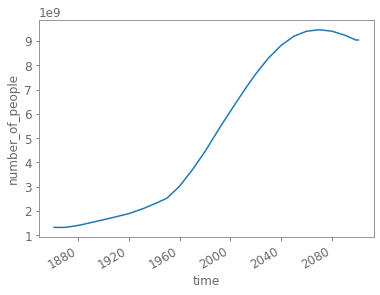

In [10]:
pop.sum(dim=('lat','lon')).plot()

In [9]:
# calculate Falkenmark index
if calc_falkenmark: 
    # load monthly population
    fn_pop = 'corrected_population_histsoc_rcp26soc_0p5deg_annual_1861-2100.nc4'
    
    # new population (only rcp26 based) 
    pop = load_pop(fn_pop)
    
    # loop over models
    for model in models:

        # loop over GCM forcings
        for forcing in forcings: 

            print('processing '+model + ' ' + forcing)
            for scenario in scenarios:


                falkenmark_index    = calc_falkenmark_index(model, forcing, scenario, pop, da_cellarea, landmask, flag_save=True)

                falkenmark_exposure = calc_falkenmark_exposure(falkenmark_index, falkenmark_threshold, landmask,  lifetimedir, model, forcing, scenario, flag_save=True)

# Calculate water deficit




In [ ]:
if calc_waterdeficit:

    fn_pop = 'corrected_population_histsoc_rcp26soc_0p5deg_annual_1861-2100.nc4'
    pop = load_pop(fn_pop)

    # loop over models
    for model in models:

        # loop over GCM forcings
        for forcing in forcings: 
            print('processing '+model + ' ' + forcing)

            for scenario in scenarios:

                calc_water_deficit(model, forcing, scenario, da_cellarea, landmask, pop)

In [ ]:
# calculate and save water deficit, and water withdrawal with population constant at 2005 level 
def calc_water_deficit_cstpop(model, forcing, scenario, da_cellarea, landmask, pop):

    # load grid cell runoff
    qtot = load_simulation('qtot', datadir, model, forcing, scenario)

    # load discharge into gricell from directly upstream grid cells
    dis_upstream = load_simulation('dis_directupstream', datadir, model, forcing, scenario, flag_postprocessed=True)

    # calculate water availability (q_avail)
    q_avail_withoutefr = dis_upstream * 1000/da_cellarea + qtot # UNITS! dis is in m³/s, convert to mm/m²s

    # subtract envrironmental flow requirement of water availability
    q_avail =  q_avail_withoutefr - get_efr(q_avail_withoutefr)
    del  dis_upstream, q_avail_withoutefr
    
    # put hard condition of setting negative water availabilities to 0 (this is a problem for the simulations of H08)
    q_avail = q_avail.where(q_avail>0,0)

    # load water withdrawal data (demand)
    ptotww = load_simulation('ptotww', datadir, model, forcing, scenario, flag_postprocessed=True)

    # solve this more ellegantly

    # fix the time dimension. 
    qtot = qtot.assign_coords(time = d_time_ncfile[scenario])
 
    days_in_month = []
    for q_avail_month in qtot.time.values:
        days_in_month.append(pd.to_datetime(q_avail_month).days_in_month)

    del qtot
    
    secs_in_month = np.expand_dims(np.array(days_in_month) * 24*60*60, axis=(1,2))
    
    pop = pop.where(landmask).sel(time='2005-12-31') 

    # hardcoded bit to get time dimension right
    if phase == '3b': 
        if scenario == 'historical': 
            time_ds = xr.open_dataset(lifetimedir+'falkenmark/cwatm/cwatm_gfdl-esm4_historical_falkenmark_global_annual_landarea_1861_2014.nc4')['exposure'].time
        else: 
            time_ds = xr.open_dataset(lifetimedir+'falkenmark/cwatm/cwatm_gfdl-esm4_ssp126_falkenmark_global_annual_landarea_2015_2100.nc4')['exposure'].time
    elif phase == '2b': 
        if scenario == 'historical': 
            time_ds = xr.open_dataset(lifetimedir+'falkenmark/cwatm/cwatm_hadgem2-es_historical_falkenmark_global_annual_landarea_1861_2005.nc4')['exposure'].time
        else: 
            time_ds = xr.open_dataset(lifetimedir+'falkenmark/cwatm/cwatm_ipsl-cm5a-lr_rcp26_falkenmark_global_annual_landarea_2006_2099.nc4')['exposure'].time

    # calculate water deficit
    water_deficit = ((ptotww - q_avail) * da_cellarea/1000  * secs_in_month)  #m³
    
    withdrawal = (ptotww*da_cellarea/1000 * secs_in_month).groupby('time.year').sum().rename({'year':'time'})

    del q_avail, ptotww   

    water_deficit_annual = water_deficit.where(water_deficit>0).groupby('time.year').sum().rename({'year':'time'})
    
    if phase == '2b': 
        # fix the time dimension. 
        if scenario == 'historical': 
            water_deficit_annual = water_deficit_annual.assign_coords(time = pd.date_range(start='1861', end='2006', freq='Y'))
            withdrawal  = withdrawal.assign_coords(time = pd.date_range(start='1861', end='2006', freq='Y'))
        else: 
            water_deficit_annual = water_deficit_annual.assign_coords(time = pd.date_range(start='2006', end='2100', freq='Y'))
            withdrawal  = withdrawal.assign_coords(time = pd.date_range(start='2006', end='2100', freq='Y'))
    elif phase == '3b': 
        # fix the time dimension. 
        if scenario == 'historical': 
            water_deficit_annual = water_deficit_annual.assign_coords(time = pd.date_range(start='1850', end='2015', freq='Y'))
            withdrawal  = withdrawal.assign_coords(time = pd.date_range(start='1850', end='2015', freq='Y'))
        else: 
            water_deficit_annual = water_deficit_annual.assign_coords(time = pd.date_range(start='2015', end='2101', freq='Y'))
            withdrawal  = withdrawal.assign_coords(time = pd.date_range(start='2015', end='2101', freq='Y'))
            
            
    water_deficit_perperson = (water_deficit_annual.where(pop)/pop).assign_coords(time= time_ds.values) 

    withdrawal_perperson = (withdrawal.where(pop) / pop).assign_coords(time= time_ds.values)


    # save into new variables
    save_to_lifetimedir(water_deficit_perperson, 'h08waterdeficitcstpop', model, forcing, scenario, annual = True)
    save_to_lifetimedir(withdrawal_perperson, 'h08withdrawalcstpop', model, forcing, scenario, annual = True)    
    

In [11]:
# calculate and save water deficit, and water withdrawal with population constant at 2005 level 
def calc_water_deficit_cstpop(model, forcing, scenario, da_cellarea, landmask, pop):

    # load grid cell runoff
    qtot = load_simulation('qtot', datadir, model, forcing, scenario)

    # load discharge into gricell from directly upstream grid cells
    dis_upstream = load_simulation('dis_directupstream', datadir, model, forcing, scenario, flag_postprocessed=True)

    # calculate water availability (q_avail)
    q_avail_withoutefr = dis_upstream * 1000/da_cellarea + qtot # UNITS! dis is in m³/s, convert to mm/m²s

    # subtract envrironmental flow requirement of water availability
    q_avail =  q_avail_withoutefr - get_efr(q_avail_withoutefr)
    del  dis_upstream, q_avail_withoutefr
    
    # put hard condition of setting negative water availabilities to 0 (this is a problem for the simulations of H08)
    q_avail = q_avail.where(q_avail>0,0)

    # load water withdrawal data (demand)
    ptotww = load_simulation('ptotww', datadir, model, forcing, scenario, flag_postprocessed=True)

    # solve this more ellegantly

    # fix the time dimension. 
    qtot = qtot.assign_coords(time = d_time_ncfile[scenario])
 
    days_in_month = []
    for q_avail_month in qtot.time.values:
        days_in_month.append(pd.to_datetime(q_avail_month).days_in_month)

    del qtot
    
    secs_in_month = np.expand_dims(np.array(days_in_month) * 24*60*60, axis=(1,2))
    
    pop = pop.where(landmask).sel(time='2005-12-31') 

    # hardcoded bit to get time dimension right
    if phase == '3b': 
        if scenario == 'historical': 
            time_ds = xr.open_dataset(lifetimedir+'falkenmark/cwatm/cwatm_gfdl-esm4_historical_falkenmark_global_annual_landarea_1861_2014.nc4')['exposure'].time
        else: 
            time_ds = xr.open_dataset(lifetimedir+'falkenmark/cwatm/cwatm_gfdl-esm4_ssp126_falkenmark_global_annual_landarea_2015_2100.nc4')['exposure'].time
    elif phase == '2b': 
        if scenario == 'historical': 
            time_ds = xr.open_dataset(lifetimedir+'falkenmark/cwatm/cwatm_hadgem2-es_historical_falkenmark_global_annual_landarea_1861_2005.nc4')['exposure'].time
        else: 
            time_ds = xr.open_dataset(lifetimedir+'falkenmark/cwatm/cwatm_ipsl-cm5a-lr_rcp26_falkenmark_global_annual_landarea_2006_2099.nc4')['exposure'].time

    # calculate water deficit
    water_deficit = ((ptotww - q_avail) * da_cellarea/1000  * secs_in_month)  #m³
    
    withdrawal = (ptotww*da_cellarea/1000 * secs_in_month).groupby('time.year').sum().rename({'year':'time'})

    del q_avail, ptotww   

    water_deficit_annual = water_deficit.where(water_deficit>0).groupby('time.year').sum().rename({'year':'time'})
    
    if phase == '2b': 
        # fix the time dimension. 
        if scenario == 'historical': 
            water_deficit_annual = water_deficit_annual.assign_coords(time = pd.date_range(start='1861', end='2006', freq='Y'))
            withdrawal  = withdrawal.assign_coords(time = pd.date_range(start='1861', end='2006', freq='Y'))
        else: 
            water_deficit_annual = water_deficit_annual.assign_coords(time = pd.date_range(start='2006', end='2100', freq='Y'))
            withdrawal  = withdrawal.assign_coords(time = pd.date_range(start='2006', end='2100', freq='Y'))
    elif phase == '3b': 
        # fix the time dimension. 
        if scenario == 'historical': 
            water_deficit_annual = water_deficit_annual.assign_coords(time = pd.date_range(start='1850', end='2015', freq='Y'))
            withdrawal  = withdrawal.assign_coords(time = pd.date_range(start='1850', end='2015', freq='Y'))
        else: 
            water_deficit_annual = water_deficit_annual.assign_coords(time = pd.date_range(start='2015', end='2101', freq='Y'))
            withdrawal  = withdrawal.assign_coords(time = pd.date_range(start='2015', end='2101', freq='Y'))
            
            
    water_deficit_perperson = (water_deficit_annual.where(pop)/pop).assign_coords(time= time_ds.values) 

    withdrawal_perperson = (withdrawal.where(pop) / pop).assign_coords(time= time_ds.values)


    # save into new variables
    save_to_lifetimedir(water_deficit_perperson, 'waterdeficitcstpop', model, forcing, scenario, annual=True)
    save_to_lifetimedir(withdrawal_perperson, 'withdrawalcstpop', model, forcing, scenario, annual = True)    
    

In [12]:
if calc_waterdeficit:

    fn_pop = 'corrected_population_histsoc_rcp26soc_0p5deg_annual_1861-2100.nc4'
    pop = load_pop(fn_pop)

    # loop over models
    for model in models:

        # loop over GCM forcings
        for forcing in forcings: 
            print('processing '+model + ' ' + forcing)

            for scenario in scenarios:

                #calc_water_deficit(model, forcing, scenario, da_cellarea, landmask, pop)
                calc_water_deficit_cstpop(model, forcing, scenario, da_cellarea, landmask, pop)

                # done for evaluation
                # calc_total_water_withdrawal(model, forcing, scenario, da_cellarea, landmask, pop)

In [13]:
def calc_water_deficit_duration(model, forcing, scenario, da_cellarea, landmask):

    # load grid cell runoff
    qtot = load_simulation('qtot', datadir, model, forcing, scenario)

    # load discharge into gricell from directly upstream grid cells
    dis_upstream = load_simulation('dis_directupstream', datadir, model, forcing, scenario, flag_postprocessed=True)

    # calculate water availability (q_avail)
    q_avail_withoutefr = dis_upstream * 1000/da_cellarea + qtot # UNITS! dis is in m³/s, convert to mm/m²s

    # subtract envrironmental flow requirement of water availability
    q_avail =  q_avail_withoutefr - get_efr(q_avail_withoutefr)

    del  dis_upstream

    # put hard condition of setting negative water availabilities to 0 (this is a problem for the simulations of H08)
    q_avail = q_avail.where(q_avail>0,0)

    # load water withdrawal data (demand)
    ptotww = load_simulation('ptotww', datadir, model, forcing, scenario, flag_postprocessed=True)

    # solve this more ellegantly

    # fix the time dimension. 
    qtot = qtot.assign_coords(time = d_time_ncfile[scenario])

    days_in_month = []
    for q_avail_month in qtot.time.values:
        days_in_month.append(pd.to_datetime(q_avail_month).days_in_month)

    del qtot

    secs_in_month = np.expand_dims(np.array(days_in_month) * 24*60*60, axis=(1,2))

    if scenario == 'historical': 
        time_ds = xr.open_dataset(lifetimedir+'falkenmark/cwatm/cwatm_hadgem2-es_historical_falkenmark_global_annual_landarea_1861_2005.nc4')['exposure'].time
    else: 
        time_ds = xr.open_dataset(lifetimedir+'falkenmark/cwatm/cwatm_ipsl-cm5a-lr_rcp26_falkenmark_global_annual_landarea_2006_2099.nc4')['exposure'].time

    # calculate water deficit
    water_deficit = ((ptotww - q_avail) * da_cellarea/1000  * secs_in_month)  #m³

    del q_avail    

    # frequency
    water_deficit_nmonths_annual = (water_deficit>0).groupby('time.year').sum().rename({'year':'time'})

    # intensity
    water_deficit_max_annual = water_deficit.where(water_deficit>0).groupby('time.year').max().rename({'year':'time'})


    # if first month is water scarce
    water_deficit_first = ( (water_deficit>0).where( water_deficit.time.dt.month== 1) ==1).groupby('time.year').sum()

    # if last month is water scarce 
    water_deficit_last = ( (water_deficit>0).where(water_deficit.time.dt.month== 12) ==1).groupby('time.year').sum()


    # calculate number of water scarce events
    nevents_list = []
    for year in np.unique(water_deficit.time.dt.year.values): 

        water_deficit_year =  (water_deficit>0).where( water_deficit.time.dt.year== year, drop=True)

        # calculate number of events (row of booleans, if difference is taken, -1 (1-0) represents end of event. 
        nevents_year = ((water_deficit_year*1).diff(dim='time') ==-1).sum("time")

        # this does not include the end of the year, so add that as separate event if last month is 1
        nevents_year = nevents_year.where(water_deficit_year[-1,:,:]==0, nevents_year+1)

        # correct for events that are multiyear spanning. 
        nevents_list.append(nevents_year)


    water_deficit_nevents = xr.concat(nevents_list, dim="year").drop('time').assign_coords({"year":water_deficit_nmonths_annual.time.values})

    # loactions with multi-year events. Subtract 1 here!!! for nevents!!!!

    boolean_last = water_deficit_last.shift(year=1)==1
    boolean_first =water_deficit_first==1
    water_deficit_nevents = water_deficit_nevents.where( np.invert(boolean_last*boolean_first),water_deficit_nevents-1)


    ds_water_deficit_duration = water_deficit_nmonths_annual.to_dataset(name='nmonths')
    ds_water_deficit_duration['nevents'] = water_deficit_nevents

    # fix the time dimension. 
    if scenario == 'historical': 
        ds_water_deficit_duration = ds_water_deficit_duration.assign_coords(time = pd.date_range(start='1861', end='2006', freq='Y'))
    else: 
        ds_water_deficit_duration = ds_water_deficit_duration.assign_coords(time = pd.date_range(start='2006', end='2100', freq='Y'))

    variable = 'waterdeficitduration'

    # save water scarcity index
    filedir, filename = get_isimip_simulation_name_dir('qtot', datadir, model, forcing, scenario)
    save_dir =  lifetimedir+variable+'/'+model.lower()+'/'

    # Create a new directory because it does not exist 
    if not os.path.exists(save_dir):
        os.makedirs(save_dir)

    filename = save_dir+filename.replace('qtot', variable)

    filename = filename.replace('monthly','annual')

    if os.path.exists(filename): 
        os.system('rm '+filename)

    ds_water_deficit_duration.to_netcdf(filename)

In [ ]:
# calculate water deficit duration
if calc_waterdeficit_duration:

    # loop over models
    for model in models:

        # loop over GCM forcings
        for forcing in forcings: 
            print('processing '+model + ' ' + forcing)

            for scenario in scenarios:
                calc_water_deficit_duration(model, forcing, scenario, da_cellarea, landmask)


In [16]:
## TO UPDATE

def calc_water_deficit_intensity(model, forcing, scenario, da_cellarea, landmask, pop):

    # load grid cell runoff
    qtot = load_simulation('qtot', datadir, model, forcing, scenario)

    # load discharge into gricell from directly upstream grid cells
    dis_upstream = load_simulation('dis_directupstream', datadir, model, forcing, scenario, flag_postprocessed=True)

    # calculate water availability (q_avail)
    q_avail_withoutefr = dis_upstream * 1000/da_cellarea + qtot # UNITS! dis is in m³/s, convert to mm/m²s

    # subtract envrironmental flow requirement of water availability
    q_avail =  q_avail_withoutefr - get_efr(q_avail_withoutefr)

    del  dis_upstream

    # put hard condition of setting negative water availabilities to 0 (this is a problem for the simulations of H08)
    q_avail = q_avail.where(q_avail>0,0)

    # load water withdrawal data (demand)
    ptotww = load_simulation('ptotww', datadir, model, forcing, scenario, flag_postprocessed=True)

    # solve this more ellegantly

    # fix the time dimension. 
    qtot = qtot.assign_coords(time = d_time_ncfile[scenario])

    days_in_month = []
    for q_avail_month in qtot.time.values:
        days_in_month.append(pd.to_datetime(q_avail_month).days_in_month)

    del qtot

    secs_in_month = np.expand_dims(np.array(days_in_month) * 24*60*60, axis=(1,2))

    if scenario == 'historical': 
        time_ds = xr.open_dataset(lifetimedir+'falkenmark/cwatm/cwatm_hadgem2-es_historical_falkenmark_global_annual_landarea_1861_2005.nc4')['exposure'].time
    else: 
        time_ds = xr.open_dataset(lifetimedir+'falkenmark/cwatm/cwatm_ipsl-cm5a-lr_rcp26_falkenmark_global_annual_landarea_2006_2099.nc4')['exposure'].time

    # calculate water deficit
    water_deficit = ((ptotww - q_avail) * da_cellarea/1000  * secs_in_month)  #m³

    del q_avail    

    # intensity
    pop = pop.where(landmask)

    water_deficit_max_annual = water_deficit.where(water_deficit>0).groupby('time.year').max().rename({'year':'time'})

    ds_water_deficit_intensity = water_deficit_max_annual.to_dataset(name='waterdeficitintensity')

    # fix the time dimension. 
    if scenario == 'historical': 
        ds_water_deficit_intensity = ds_water_deficit_intensity.assign_coords(time = pd.date_range(start='1861', end='2006', freq='Y'))
    else: 
        ds_water_deficit_intensity = ds_water_deficit_intensity.assign_coords(time = pd.date_range(start='2006', end='2100', freq='Y'))

    variable = 'waterdeficitintensity'
    
    ds_water_deficit_intensity = (ds_water_deficit_intensity.where(pop)/pop).assign_coords(time= time_ds.values) 

    # save water scarcity index
    filedir, filename = get_isimip_simulation_name_dir('qtot', datadir, model, forcing, scenario)
    save_dir =  lifetimedir+variable+'/'+model.lower()+'/'

    # Create a new directory because it does not exist 
    if not os.path.exists(save_dir):
        os.makedirs(save_dir)

    filename = save_dir+filename.replace('qtot', variable)

    filename = filename.replace('monthly','annual')

    if os.path.exists(filename): 
        os.system('rm '+filename)

    ds_water_deficit_intensity.to_netcdf(filename)

In [17]:
# calculate water deficit intensity
if calc_waterdeficit_intensity:

    fn_pop =  'corrected_population_histsoc_rcp26soc_0p5deg_annual_1861-2100.nc4'

    pop = load_pop(fn_pop)

    # loop over models
    for model in models[2:]:

        # loop over GCM forcings
        for forcing in forcings: 
            print('processing '+model + ' ' + forcing)

            for scenario in scenarios:
                calc_water_deficit_intensity(model, forcing, scenario, da_cellarea, landmask, pop)


processing LPJmL gfdl-esm2m
processing LPJmL ipsl-cm5a-lr
processing LPJmL hadgem2-es
processing LPJmL miroc5
processing MATSIRO gfdl-esm2m
processing MATSIRO ipsl-cm5a-lr
processing MATSIRO hadgem2-es
processing MATSIRO miroc5


## Water deficit per sector


In [5]:
# calculate and save water deficit per sector
def calc_water_deficit_persector(model, forcing, scenario, var, da_cellarea, landmask, pop):

    # load waterwithdrawals intermediate
    sectors = ['indww','irrww','domww']

    # load grid cell runoff
    qtot = load_simulation('qtot', datadir, model, forcing, scenario)

    # load discharge into gricell from directly upstream grid cells
    dis_upstream = load_simulation('dis_directupstream', datadir, model, forcing, scenario, flag_postprocessed=True)

    # calculate water availability (q_avail)
    q_avail_withoutefr = dis_upstream * 1000/da_cellarea + qtot # UNITS! dis is in m³/s, convert to mm/m²s

    # subtract envrironmental flow requirement of water availability
    q_avail =  q_avail_withoutefr - get_efr(q_avail_withoutefr)
    del  dis_upstream

    # put hard condition of setting negative water availabilities to 0 (this is a problem for the simulations of H08)
    q_avail = q_avail.where(q_avail>0,0)


    # load water withdrawals to calculate shares
    ds_withdrawal = xr.Dataset()
    for sector in sectors:
        ds_withdrawal[sector] = load_simulation(sector, datadir, model, forcing, scenario, flag_postprocessed=True)

    ds_withdrawal['total'] = ds_withdrawal['indww']+ds_withdrawal['domww']+ds_withdrawal['irrww']
    ds_withdrawal['indww_rel'] = ds_withdrawal['indww'] / ds_withdrawal['total']
    ds_withdrawal['domww_rel'] = ds_withdrawal['domww'] / ds_withdrawal['total']

    ds_withdrawal['irrww_rel'] = ds_withdrawal['irrww'] / ds_withdrawal['total']

    # get sectoral water withdrawal data (demand)
    ptotww = ds_withdrawal[var]

    del ds_withdrawal['indww'], ds_withdrawal['irrww'], ds_withdrawal['domww'], ds_withdrawal['total']


    # scale water available with share of sectoral water demand
    q_avail = q_avail * ds_withdrawal[var+'_rel']

    del ds_withdrawal


    days_in_month = []
    for q_avail_month in qtot.time.values:
        days_in_month.append(pd.to_datetime(q_avail_month).days_in_month)

    del qtot

    secs_in_month = np.expand_dims(np.array(days_in_month) * 24*60*60, axis=(1,2))

    pop = pop.where(landmask) 

    # hardcoded bit to get time dimension right
    if phase == '3b': 
        if scenario == 'historical': 
            time_ds = xr.open_dataset(lifetimedir+'falkenmark/cwatm/cwatm_gfdl-esm4_historical_falkenmark_global_annual_landarea_1861_2014.nc4')['exposure'].time
        else: 
            time_ds = xr.open_dataset(lifetimedir+'falkenmark/cwatm/cwatm_gfdl-esm4_ssp126_falkenmark_global_annual_landarea_2015_2100.nc4')['exposure'].time
    elif phase == '2b': 
        if scenario == 'historical': 
            time_ds = xr.open_dataset(lifetimedir+'falkenmark/lpjml/lpjml_gfdl-esm2m_historical_falkenmark_global_annual_landarea_1861_2005.nc4')['exposure'].time
        else: 
            time_ds = xr.open_dataset(lifetimedir+'falkenmark/lpjml/lpjml_gfdl-esm2m_rcp26_falkenmark_global_annual_landarea_2006_2099.nc4')['exposure'].time

    # calculate water deficit
    water_deficit = ((ptotww - q_avail) * da_cellarea/1000  * secs_in_month)  #m³

    del q_avail    

    water_deficit_annual = water_deficit.where(water_deficit>0).groupby('time.year').sum().rename({'year':'time'})

    if phase == '2b': 
        # fix the time dimension. 
        if scenario == 'historical': 
            water_deficit_annual = water_deficit_annual.assign_coords(time = pd.date_range(start='1861', end='2006', freq='Y'))
        else: 
            water_deficit_annual = water_deficit_annual.assign_coords(time = pd.date_range(start='2006', end='2100', freq='Y'))
    elif phase == '3b': 
        # fix the time dimension. 
        if scenario == 'historical': 
            water_deficit_annual = water_deficit_annual.assign_coords(time = pd.date_range(start='1850', end='2015', freq='Y'))
        else: 
            water_deficit_annual = water_deficit_annual.assign_coords(time = pd.date_range(start='2015', end='2101', freq='Y'))


    water_deficit_perperson = (water_deficit_annual.where(pop)/pop).assign_coords(time= time_ds.values) 


    # save into new variables
    save_to_lifetimedir(water_deficit_perperson, var+'waterdeficit', model, forcing, scenario, annual=True)

In [6]:
# Calculate water withdrawal per sector for ISIMIP2b simulations and save then in intermediate director
def calc_ptotww_2b_persector_corrected_h08(models, forcings, scenarios, da_cellarea): 

    # calculate potential total water withdrawal for isimip2b simulations, besed on defenitions in main_2b noteboook
    for model in models:
        for forcing in forcings: 
            for scenario in scenarios:

                intermediatedir = outdir+'intermediate/'+model.lower()+'/'

                if model == 'H08': 

                    filedir, filename = get_isimip_simulation_name_dir('pirrww', datadir, model, forcing, scenario)

                    indww_filename = filename.replace('pirrww', 'indww')
                    domww_filename = filename.replace('pirrww', 'domww') 
                    irrww_filename = filename.replace('pirrww', 'irrww')
                    
                    if not os.path.exists(intermediatedir+indww_filename): 
                        print('processing indww for '+model + ' ' + forcing + ' '+scenario)  
                        print(indww_filename)
                        indww = load_simulation('amanww', datadir, model, forcing, scenario, flag_postprocessed=True)
                        indww.to_dataset(name='indww').to_netcdf(intermediatedir+indww_filename)
                        
                    else: 
                        print('Existing '+indww_filename)
                    
                    if not os.path.exists(intermediatedir+domww_filename): 
                        print('processing domww for '+model + ' ' + forcing + ' '+scenario)
                        print(domww_filename)
                        domww = load_simulation('adomww', datadir, model, forcing, scenario, flag_postprocessed=True)
                        domww.to_dataset(name='domww').to_netcdf(intermediatedir+domww_filename)
                         
                    else: 
                        print('Existing '+domww_filename)
                    
                    if not os.path.exists(intermediatedir+irrww_filename): 
        
                        if scenario != 'historical': 
                            flag_postprocessed_pirrww_h08 = True
                        else: 
                            flag_postprocessed_pirrww_h08 = False
                                                        
                        print('processing irrww for '+model + ' ' + forcing + ' '+scenario)
                        print(irrww_filename)
                        irrww = load_simulation('pirrww', datadir, model, forcing, scenario, flag_postprocessed=flag_postprocessed_pirrww_h08)
                        irrww.to_dataset(name='irrww').to_netcdf(intermediatedir+irrww_filename)
                    
                    else: 
                        print('Existing '+irrww_filename)
                        
                        
                elif model == 'CWatM': 
                    filedir, filename = get_isimip_simulation_name_dir('adomuse', datadir, model, forcing, scenario)

                    #if not os.path.exists(intermediatedir+filename.replace('adomuse', 'domww')): 
                    #    print('processing indww for '+model + ' ' + forcing + ' '+scenario)                      
                    #    domww =  load_simulation('adomww', datadir,'H08', forcing, scenario, flag_postprocessed=True)                       
                    #    domww.to_dataset(name='domww').to_netcdf(intermediatedir+filename.replace('adomuse', 'domww'))
                        
                    #if not os.path.exists(intermediatedir+filename.replace('adomuse', 'indww')):
                    #    print('processing indww for '+model + ' ' + forcing + ' '+scenario)
                    #    amanww = load_simulation('amanww', datadir, 'H08', forcing, scenario, flag_postprocessed=True)
                    #    indww.to_dataset(name='indww').to_netcdf(intermediatedir+filename.replace('adomuse', 'indww'))
                        
                    if not os.path.exists(intermediatedir+filename.replace('adomuse', 'irrww')): 
                        print('processing indww for '+model + ' ' + forcing + ' '+scenario)  
                        irrww = load_simulation('pirrww', datadir, model, forcing, scenario)                    
                        irrww.to_dataset(name='irrww').to_netcdf(intermediatedir+filename.replace('adomuse', 'irrww'))


                elif model == 'LPJmL' or model == 'MATSIRO': 
                    
                    filedir, filename = get_isimip_simulation_name_dir('pirrww', datadir, model, forcing, scenario)
                    
                    if not os.path.exists(intermediatedir+filename.replace('pirrww', 'irrww')): 
                        print('processing irrww for '+model + ' ' + forcing + ' '+scenario)  

                        # load potential irrigation water withdrawal (available for both)
                        irrww = load_simulation('pirrww', datadir, model, forcing, scenario)
                        irrww.to_dataset(name='irrww').to_netcdf(intermediatedir+filename.replace('pirrww', 'irrww'))

                        
                    #if not (os.path.exists(intermediatedir+filename.replace('pirrww', 'indww')) or os.path.exists(intermediatedir+filename.replace('pirrww', 'domww'))): 
                    #    print('processing indww and domww for '+model + ' ' + forcing + ' '+scenario)  
                        

                    #    indww = load_simulation('amanww', datadir, 'H08', forcing, scenario, flag_postprocessed=True)
                    #    domww = load_simulation('adomww', datadir, 'H08', forcing, scenario, flag_postprocessed=True)      
                        
                        # Save the variable into intermediate netCDF file
                    #    indww.to_dataset(name='indww').to_netcdf(intermediatedir+filename.replace('pirrww', 'indww'))
                    #    domww.to_dataset(name='domww').to_netcdf(intermediatedir+filename.replace('pirrww', 'domww'))

                        # water withdrawal per sector


In [11]:
calc_ptotww_2b_persector_corrected_h08(models, forcings, scenarios, da_cellarea)

Existing h08_gfdl-esm2m_historical_histsoc_co2_indww_global_monthly_1861_2005.nc4
Existing h08_gfdl-esm2m_historical_histsoc_co2_domww_global_monthly_1861_2005.nc4
Existing h08_gfdl-esm2m_historical_histsoc_co2_irrww_global_monthly_1861_2005.nc4
Existing h08_gfdl-esm2m_ewembi_rcp26_rcp26soc_co2_indww_global_monthly_2006_2099.nc4
Existing h08_gfdl-esm2m_ewembi_rcp26_rcp26soc_co2_domww_global_monthly_2006_2099.nc4
Existing h08_gfdl-esm2m_ewembi_rcp26_rcp26soc_co2_irrww_global_monthly_2006_2099.nc4
Existing h08_gfdl-esm2m_ewembi_rcp60_rcp60soc_co2_indww_global_monthly_2006_2099.nc4
Existing h08_gfdl-esm2m_ewembi_rcp60_rcp60soc_co2_domww_global_monthly_2006_2099.nc4
Existing h08_gfdl-esm2m_ewembi_rcp60_rcp60soc_co2_irrww_global_monthly_2006_2099.nc4
Existing h08_ipsl-cm5a-lr_historical_histsoc_co2_indww_global_monthly_1861_2005.nc4
Existing h08_ipsl-cm5a-lr_historical_histsoc_co2_domww_global_monthly_1861_2005.nc4
Existing h08_ipsl-cm5a-lr_historical_histsoc_co2_irrww_global_monthly_1861_2

In [8]:
calc_withdrawal_persector = True

In [9]:
def calc_water_withdrawal_persector(var, model, forcing, scenario, da_cellarea, landmask, pop):

    ww = load_simulation(var, datadir, model, forcing, scenario, flag_postprocessed=True)

    days_in_month = []
    for q_avail_month in ww.time.values:
        days_in_month.append(pd.to_datetime(q_avail_month).days_in_month)

    secs_in_month = np.expand_dims(np.array(days_in_month) * 24*60*60, axis=(1,2))

    if scenario == 'historical': 
        time_ds = xr.open_dataset(lifetimedir+'falkenmark/lpjml/lpjml_gfdl-esm2m_historical_falkenmark_global_annual_landarea_1861_2005.nc4')['exposure'].time
    else: 
        time_ds = xr.open_dataset(lifetimedir+'falkenmark/lpjml/lpjml_gfdl-esm2m_rcp26_falkenmark_global_annual_landarea_2006_2099.nc4')['exposure'].time


    withdrawal = (ww*da_cellarea/1000 * secs_in_month).groupby('time.year').sum().rename({'year':'time'})

    # fix the time dimension. 
    if scenario == 'historical': 
        withdrawal  = withdrawal.assign_coords(time = pd.date_range(start='1861', end='2006', freq='Y'))

    else: 
        withdrawal  = withdrawal.assign_coords(time = pd.date_range(start='2006', end='2100', freq='Y'))

    # save into new variables
    save_to_lifetimedir(withdrawal, var, model, forcing, scenario, annual = True)

In [10]:
if calc_withdrawal_persector:

    fn_pop =  'corrected_population_histsoc_rcp26soc_0p5deg_annual_1861-2100.nc4'
    pop = load_pop(fn_pop)

    variables = ['irrww','indww','domww']

    # loop over models
    for model in models:
        
        # only use dom and indww from H08, as others are corrupted. 
        if model != 'H08': 
            
            variables = [variables[0]]
        # loop over GCM forcings
        for forcing in forcings: 

            for var in variables: 
                print('processing '+var+' '+model + ' ' + forcing)
                for scenario in scenarios:
                    print(scenario)
                    calc_water_withdrawal_persector(var, model, forcing, scenario, da_cellarea, landmask, pop)


processing irrww H08 gfdl-esm2m
historical
rcp26


KeyError: 'irrww'

In [20]:
if calc_deficit_persector:

    fn_pop =  'corrected_population_histsoc_rcp26soc_0p5deg_annual_1861-2100.nc4'
    pop = load_pop(fn_pop)

    variables = ['indww','irrww','domww']
    for var in variables: 

        # loop over models
        for model in models:

            # loop over GCM forcings
            for forcing in forcings: 

                print('processing '+var+' '+model + ' ' + forcing)
                
                for scenario in scenarios:
                    print(scenario)
                    calc_water_deficit_persector(model, forcing, scenario, var, da_cellarea, landmask, pop)


processing indww H08 gfdl-esm2m
historical


KeyError: 'domww'